In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from glob import glob
import fitsio as ft

In [2]:
def make_hp(nside, hpix, val, fill=0.0):
    
    map_ = np.zeros(12*nside*nside)
    map_[:] = fill
    map_[hpix] = val
    
    return map_

def prepare(weight):
    
    table = ft.read(weight) 
    
    vlow, vhigh = np.percentile(table['weight'], [1, 99])
    val = table['weight'].clip(vlow, vhigh)
    map_ = make_hp(256, table['hpix'], val.mean(axis=1))
    
    count_ = map_.clip(0.0, 1.0)
    
    return map_, count_


def merge_weights(weights, nside):
    
    npix = 12*nside*nside
    weight_map = np.zeros(npix)
    count_map = np.zeros(npix)

    for weight in weights:

        map_, count_ = prepare(weight)

        weight_map += map_
        count_map += count_
        
    is_good = count_map > 0.0
    
    selection = np.zeros_like(weight_map)
    selection[:] = hp.UNSEEN
    selection[is_good] = weight_map[is_good]/count_map[is_good]
        
    return selection

# LRGs
These are selection functions trained with imaging maps in NSIDE=256.

In [3]:
lrgweights = glob('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/v3/sv3nn_lrg_*_256/nn-weights.fits')
lrgweights

['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/v3/sv3nn_lrg_sdecals_256/nn-weights.fits',
 '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/v3/sv3nn_lrg_ndecals_256/nn-weights.fits',
 '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/v3/sv3nn_lrg_bmzls_256/nn-weights.fits']

In [4]:
selection_lrg = merge_weights(lrgweights, 256)

## ELGs
These are ELG selection functions trained with imaging maps in NSIDE=256.

In [5]:
elgweights = glob('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/v2/sv3nn_elg_*s_256/nn-weights.fits')
elgweights

['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/v2/sv3nn_elg_bmzls_256/nn-weights.fits',
 '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/v2/sv3nn_elg_sdecals_256/nn-weights.fits',
 '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/v2/sv3nn_elg_ndecals_256/nn-weights.fits']

In [6]:
selection_elg = merge_weights(elgweights, 256)

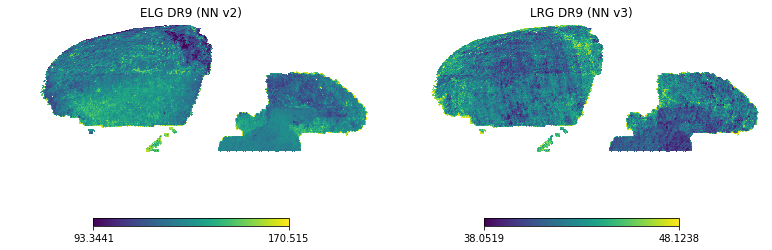

In [7]:
fg, ax = plt.subplots(ncols=2, figsize=(14, 4.))
fg.subplots_adjust(wspace=0.0)

for i, (sel, title) in enumerate(zip([selection_elg, selection_lrg],
                                     ['ELG DR9 (NN v2)', 'LRG DR9 (NN v3)'])):
    plt.sca(ax[i])
    hp.mollview(sel, rot=(120, ), hold=True, title=title, badcolor='w')

In [7]:
#hp.write_map('./lrg_selection_v3.fits', selection_lrg, fits_IDL=False, dtype=np.float64)
np.save('./lrg_selection_v3_hp256.npy', selection_lrg, allow_pickle=False)

In [8]:
#hp.write_map('./elg_selection_v2.fits', selection_elg, fits_IDL=False, dtype=np.float64)
np.save('./elg_selection_v2_hp256.npy', selection_elg, allow_pickle=False)

## Reading

In [9]:
lrg_ = np.load('./lrg_selection_v3_hp256.npy')

In [10]:
lrg_

array([-1.6375e+30, -1.6375e+30, -1.6375e+30, ..., -1.6375e+30,
       -1.6375e+30, -1.6375e+30])

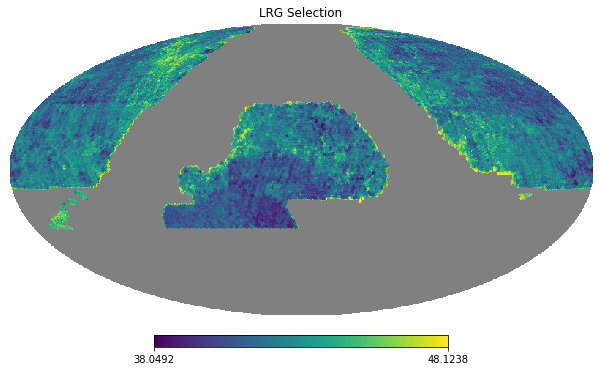

In [11]:
hp.mollview(lrg_, title='LRG Selection')